In [1]:
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
from importlib import reload
import tqdm.notebook as tqdm

In [2]:
import fast_binning

# Binning analysis
The basic idea of the binning code is to visualise the distribution of different measured _variables_ (metrics) e.g. photodiode intensity, spatter, etc. by binning them against different _coordinates_ (independent variables) e.g. spatial position, scan orientation, etc. 
The resulting bins can be visualised in different ways by plotting different quantities per bin such as the mean, count, or standard deviation for a given variable. 
The easiest way to get what this is about is to look at [the notebook](binning_v2.ipynb). 

### _Code breakdown_
The key parts of the code are:
* The `DataBins` object, which stores all the data for a particular coordinate or set of coordinates in bins.
* The `process_dataframe` function, which takes a pandas dataframe and any number of `DataBins` instances as input, then carries out the appropriate binning over the dataframe.

The rest of the code in [fast_binning.py](fast_binning.py) basically consists of various helper functions.
* `optimal_grid` can be used to generate appropriate bins given an initial user 'guess'. This is helpful for binning against 'sparse' coordinates, such as XY plane coordinates (for certain builds).
* `expand_df` adds some common 'derived' variables and coordinates into an initial dataframe: orientation, speed, acceleration, distance traversed.
* `plot_bins` produces a quick plot from 3 `DataBins` with coordinates corresponding to build height, XY position, and scan path orientation. 

### Demonstration

In [3]:
dir_ = "onderive_data_2/12Hz/"

In [4]:
# grab a random file and use it to work out what metrics need to be included in the binning procedure.
test_path = dir_ + "layer360.csv"
test = pd.read_csv(test_path,header=0,index_col=0)
var_labels = test.loc[:,"Photodiode":].columns.drop(["Z","Frame","Layer"]) # a list of metrics that correspond to dependent variables. 
var_labels = var_labels.append(pd.Index(["Distance traversed"])) # An extra variable, it's value is calculated by the expand_df function.

# Also use the test file to work out a rough bin 'mesh' for the build bed plane bins. 
x_grid,y_grid = fast_binning.optimal_grid(["X","Y"],
                                          test,
                                          [4,4],
                                          sub_divisions=6,
                                          aux_variable="P",
                                          tol=1000.0)

/tmp/ipykernel_999/101865346.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0].scatter(example.loc[:,"X"].values,example.loc[:,"Y"].values,


Text(-75000, 77000, 'Coloured by coordinate:\norientation')

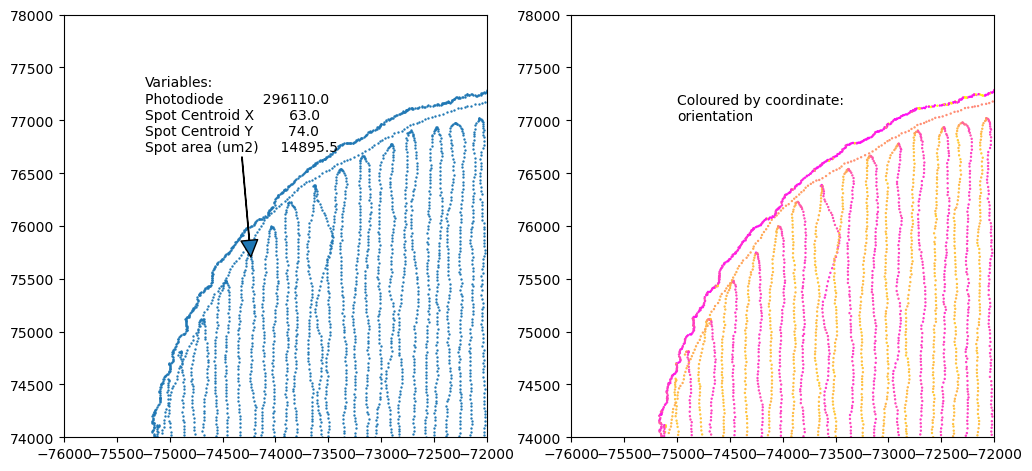

In [5]:
example = fast_binning.expand_df(test)
xmin = -76000 ; xmax = -72000
ymin = 74000 ; ymax = 78000

example = example[(example.loc[:,"P"]>0.0)
                  & (example.loc[:,"X"]<-xmax) & (example.loc[:,"X"]>xmin) 
                  & (example.loc[:,"Y"]<ymax) & (example.loc[:,"Y"]>ymin)]

fig,ax = plt.subplots(ncols=2,figsize=(12,6))

ax[0].scatter(example.loc[:,"X"].values,example.loc[:,"Y"].values,
           #c=(example.loc[:,"X"].values-xmin)+(example.loc[:,"Y"].values-ymin)*(xmax-xmin),
           s=0.5,
           cmap="spring")
ax[0].set_aspect("equal")
ax[0].set_xlim([xmin,xmax])
ax[0].set_ylim([ymin,ymax])

ax[0].annotate("Variables:\n"+example.iloc[300].loc["Photodiode":"Spot area (um2)"].to_string(),
               example.iloc[300].loc["X":"Y"].to_numpy(),
               example.iloc[300].loc["X":"Y"].to_numpy()+np.array([-1000,1000]),
               arrowprops={"width":0.3})

ax[1].scatter(example.loc[:,"X"].values,example.loc[:,"Y"].values,
           c=example.loc[:,"Orientation"].values,
           s=0.5,
           cmap="spring")
ax[1].set_aspect("equal")
ax[1].set_xlim([xmin,xmax])
ax[1].set_ylim([ymin,ymax])

ax[1].text(-75000,77000,"Coloured by coordinate:\norientation")

## 12Hz blower frequency data
Data processing pipeline:
- Setup appropriate bins (semi-automated) 
- expand with additional variables 
- compute binning

The variable `dir_` should point to the directory containing all of the ATLAS metrics csv files for a build. 

In [6]:
# Setup objects that correspond to the bins over 'coordinates'. 
XY_data = fast_binning.DataBins(["X","Y"],[x_grid,y_grid],var_labels)
th_data = fast_binning.DataBins(["Orientation"],[np.linspace(-np.pi,np.pi,41,endpoint=True)],var_labels)
Zl_data = fast_binning.DataBins(["Layer"],[np.arange(0,181,9)-0.5],var_labels)

In [7]:
# loop over all of the metric csv files, and process using the bin objects. 
for file in tqdm.tqdm(listdir(dir_)):
    df = pd.read_csv(dir_ + file,header=0,index_col=0,engine='c')
    df = fast_binning.expand_df(df) # Calculate extra derived variables. 
    fast_binning.process_dataframe(df,XY_data,th_data,Zl_data)
# If this runs slowly, it's due to the overhead of reading in the csv files (see profiling section at the end of the notebook).
# Should be easy to parallelise if required. 

  0%|          | 0/180 [00:00<?, ?it/s]

## 30Hz blower frequency data
- repeat the data processing pipeline used above. 

In [8]:
dir_ = "onderive_data_2/30Hz/"

XY_data_30Hz = fast_binning.DataBins(["X","Y"],[x_grid,y_grid],var_labels)
th_data_30Hz = fast_binning.DataBins(["Orientation"],[np.linspace(-np.pi,np.pi,41,endpoint=True)],var_labels)
Zl_data_30Hz = fast_binning.DataBins(["Layer"],[np.arange(0,181,9)-0.5],var_labels)

In [9]:
for file in tqdm.tqdm(sorted(listdir(dir_),
                             key=lambda f: int(f.split(".")[0][5:]))[:181]
                      ):
    df = pd.read_csv(dir_ + file,header=0,index_col=0,engine='c')
    df = fast_binning.expand_df(df)
    fast_binning.process_dataframe(df,XY_data_30Hz,th_data_30Hz,Zl_data_30Hz)

  0%|          | 0/181 [00:00<?, ?it/s]

In [10]:
reload(fast_binning)

<module 'fast_binning' from '/root/docs/gas_flow_project/fast_binning.py'>

## Visualisations
We can visualise these bins for different dependent variables (in this case, different metrics), and different quantities for each bin (e.g. mean values per bin, std per bin, etc.).

First set of bins: mean photodiode values per bin. Plotted against height/layer, XY position in the bed, and scan path orientation. 

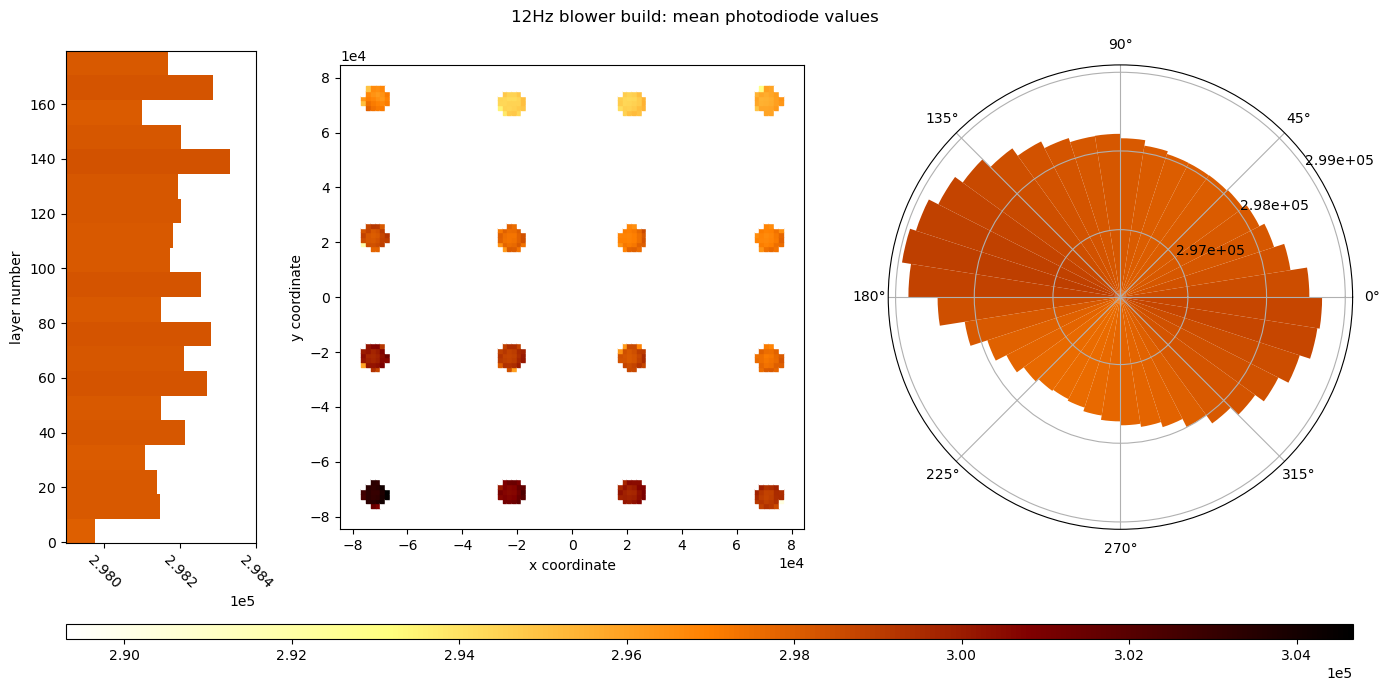

In [11]:
fig = plt.figure(figsize=(14.0,7.0))
ax_z,ax_xy,ax_th,vrange_0 = fast_binning.plot_bins(fig,
                       "Photodiode",
                       XY_data,
                       th_data,
                       Zl_data,
                       "mean",
                       normalisation='linear')
fig.suptitle("12Hz blower build: mean photodiode values")
fig.tight_layout()

Note that in the second plot, `vrange` returned from the previous plotting function is passed as a variable in order to use the same value range and colorbar as above. 

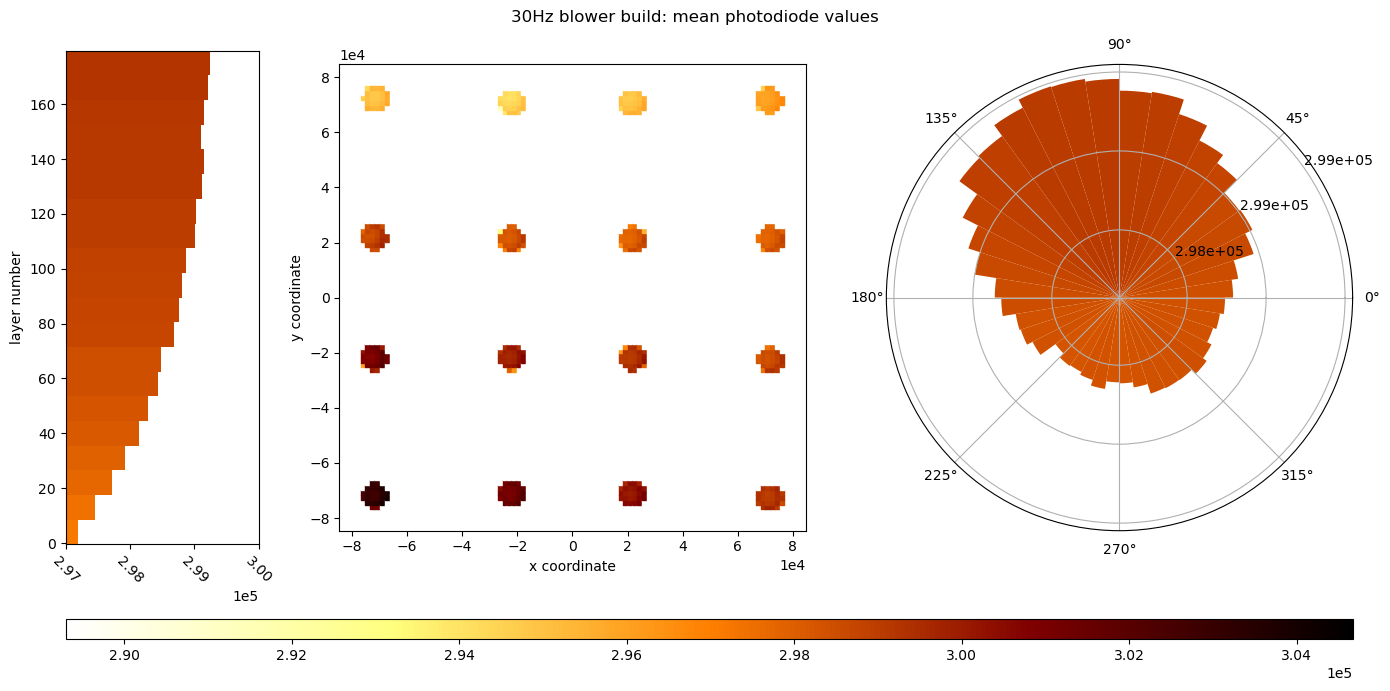

In [12]:
fig = plt.figure(figsize=(14.0,7.0))
ax_z,ax_xy,ax_th,vrange_0 = fast_binning.plot_bins(fig,
                       "Photodiode",
                       XY_data_30Hz,
                       th_data_30Hz,
                       Zl_data_30Hz,
                       vrange=vrange_0,
                       quantity="mean",
                       normalisation='linear')
fig.suptitle("30Hz blower build: mean photodiode values")
fig.tight_layout()

For this second set of bins, the quantity shown is the average total spatter area per unit of distance traversed along the scan path. Note that you can add plot any ATLAS metric here. 

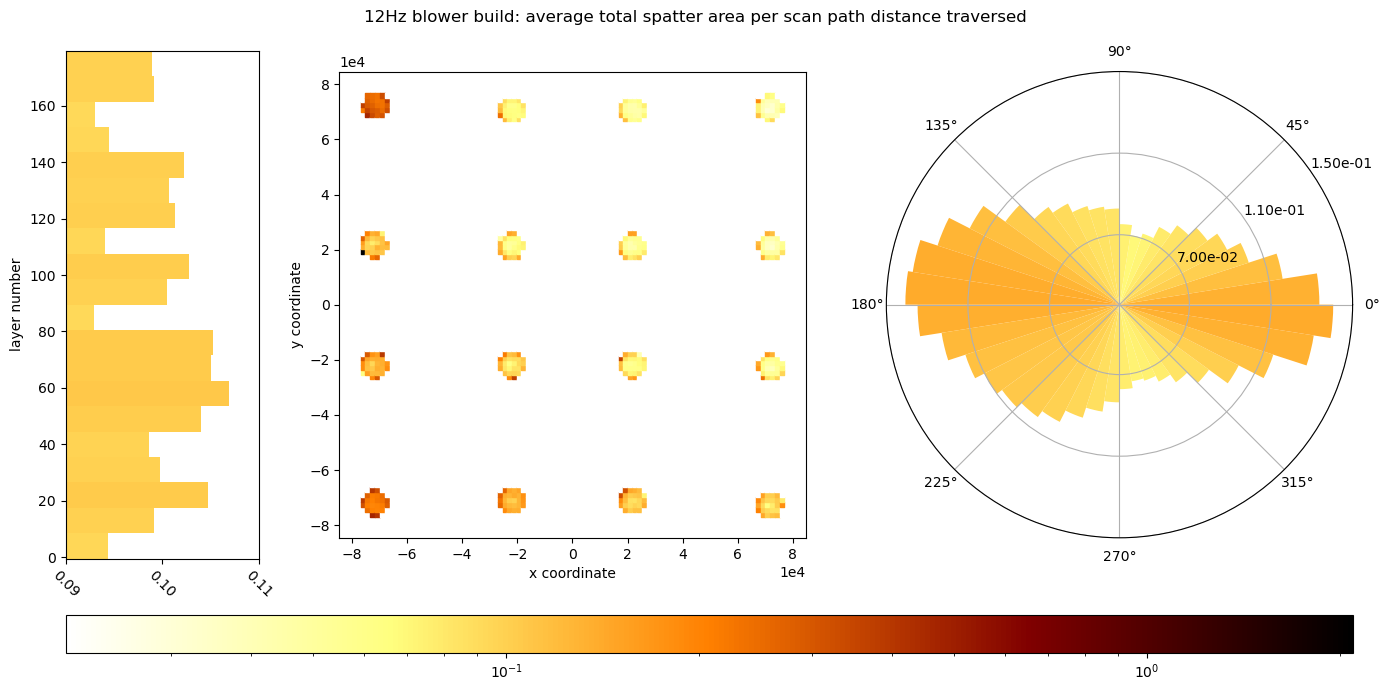

In [13]:
fig = plt.figure(figsize=(14.0,7.0))
ax_z,ax_xy,ax_th,vrange_1 = fast_binning.plot_bins(fig,
                       "Spatter total area",
                       XY_data,
                       th_data,
                       Zl_data,
                       "per_traversed",
                       normalisation='log')
fig.suptitle("12Hz blower build: average total spatter area per scan path distance traversed")
fig.tight_layout()

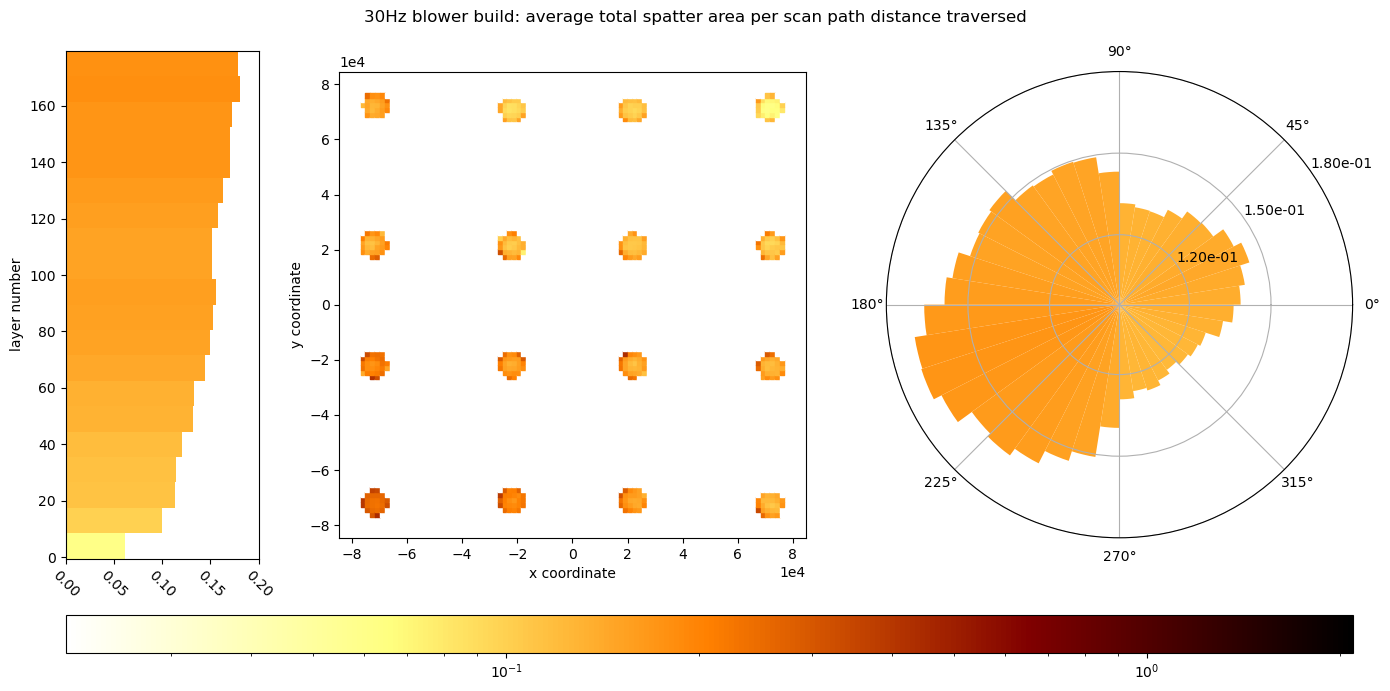

In [14]:
fig = plt.figure(figsize=(14.0,7.0))
ax_z,ax_xy,ax_th,vrange_1 = fast_binning.plot_bins(fig,
                       "Spatter total area",
                       XY_data_30Hz,
                       th_data_30Hz,
                       Zl_data_30Hz,
                       vrange=vrange_1,
                       quantity="per_traversed",
                       normalisation='log')
fig.suptitle("30Hz blower build: average total spatter area per scan path distance traversed")
fig.tight_layout()

## Separate binning by component
Using the 12Hz data again.

In [15]:
# Once again, use the test file to work out a rough bin 'mesh' for the build bed plane bins. 
dir_ = "onderive_data_2/12Hz/"
test_path = dir_ + "layer360.csv"
test = pd.read_csv(test_path,header=0,index_col=0)
x_grid,y_grid = fast_binning.optimal_grid(["X","Y"],
                                          test,
                                          [4,4],
                                          sub_divisions=1,
                                          aux_variable="P",
                                          tol=1000.0)

In [16]:
# Setup objects that correspond to the bins over 'coordinates' - here the rough mesh over XY is a proxy for the build components. 
th_component_data = fast_binning.DataBins(["X","Y","Orientation"],
                                          [x_grid,y_grid,np.linspace(-np.pi,np.pi,41,endpoint=True)],
                                          var_labels)

In [17]:
# Note that due to the large overhead of reading .csv files, it would be faster to do this in the same loop as the one above. 
for file in tqdm.tqdm(listdir(dir_)):
    df = pd.read_csv(dir_ + file,header=0,index_col=0,engine='c')
    df = fast_binning.expand_df(df) # Calculate extra derived variables. 
    fast_binning.process_dataframe(df,th_component_data)

  0%|          | 0/180 [00:00<?, ?it/s]

DataBins objects can be sliced to produce a new DataBins object. How slices are taken should correspond to the order of the `coord_names` attribute. The code snippet in the cell below gives an example. 

In [18]:
print("original coords = [{},{},{}]".format(*th_component_data.coord_names))
print("original # bins per coord = [{},{},{}]".format(*th_component_data.nbin))
th_component_data_00 = th_component_data[0,0,:]
print("sliced object's coords = [{}]".format(*th_component_data_00.coord_names))
print("sliced object's # bins per coord = [{}]".format(*th_component_data_00.nbin))

original coords = [X,Y,Orientation]
original # bins per coord = [9,9,42]
sliced object's coords = [Orientation]
sliced object's # bins per coord = [42]


Can make use of slicing to plot orientation bins _per component_ i.e. per XY plane bin. 

Text(0.5, 0.98, '12Hz blower build: mean photodiode across orientation and location')

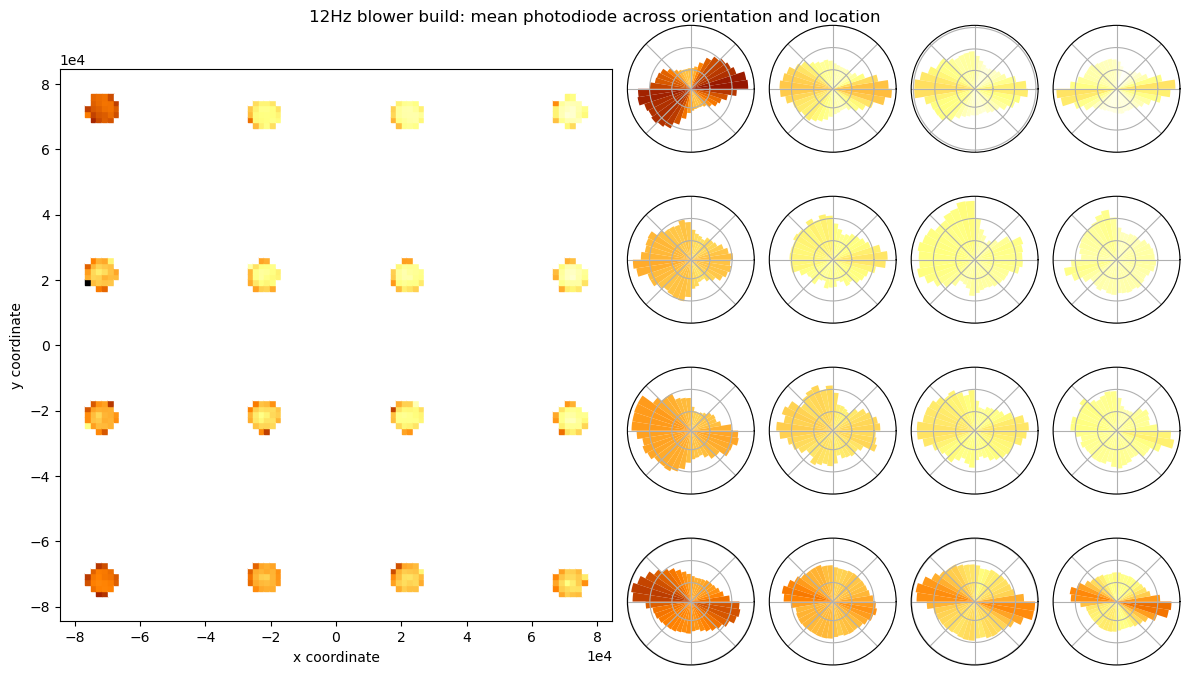

In [65]:
fig = plt.figure(figsize=(12,7))
spec = fig.add_gridspec(4,8)

# Just replot the planar data
ax0 = fig.add_subplot(spec[:,:4])
fast_binning.plot_planar_bins(ax0,XY_data,"Spatter total area","per_traversed",vrange=vrange_1,normalisation='log')

# Now plot bins over orientation for each component.
# Note the strange indexing - component [0,0] is oat the bottom left of the planar plot. 
for i in range(4):
    for j in range(4):
        ax = fig.add_subplot(spec[3-j,4+i],polar=True)
        fast_binning.plot_orientation_bins(ax,th_component_data[2*i,2*j,:],"Spatter total area","per_traversed",vrange=vrange_1,normalisation='log')
        # Clean up these plots - they're too small for labels really
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        
fig.tight_layout()
fig.suptitle("12Hz blower build: mean photodiode across orientation and location")

## Profiling the code
The main overhead is from reading in the csv files. 

In [20]:
from copy import deepcopy

In [21]:
XY_data_test = deepcopy(XY_data_30Hz)
th_data_test = deepcopy(th_data_30Hz)
Zl_data_test = deepcopy(Zl_data_30Hz)

In [22]:
%%prun
df = pd.read_csv(dir_ + file,header=0,index_col=0,engine='c')
df = fast_binning.expand_df(df)
fast_binning.process_dataframe(df,XY_data_test,th_data_test,Zl_data_test)

         324666 function calls (319052 primitive calls) in 1.471 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.768    0.768    0.779    0.779 {method 'read_low_memory' of 'pandas._libs.parsers.TextReader' objects}
      350    0.092    0.000    0.092    0.000 {pandas._libs.algos.take_2d_axis0_float64_float64}
      314    0.053    0.000    0.053    0.000 {built-in method scipy.fft._pocketfft.pypocketfft.c2c}
 1225/881    0.048    0.000    0.063    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.041    0.041    0.041    0.041 {built-in method io.open}
      192    0.022    0.000    0.022    0.000 fast_binning.py:10(add_at)
        4    0.019    0.005    0.019    0.005 managers.py:2194(_stack_arrays)
     2609    0.018    0.000    0.018    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        2    0.017    0.009    0.037    0.018 managers.py:2224(_merge_blocks)


Example of the entire procedure.

In [95]:
reload(fast_binning)

<module 'fast_binning' from '/root/docs/gas_flow_project/fast_binning.py'>

[]

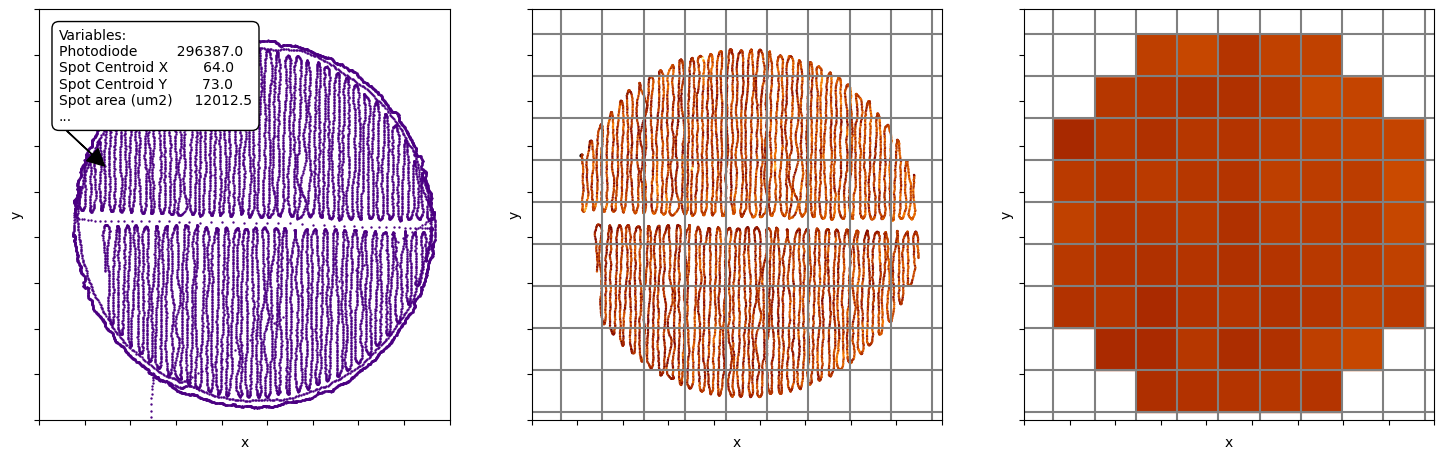

In [103]:
example = fast_binning.expand_df(test)
xmin = -76000 ; xmax = -67000
ymin = 69000 ; ymax = 78000

example = example[(example.loc[:,"X"]<xmax) & (example.loc[:,"X"]>xmin) 
                  & (example.loc[:,"Y"]<ymax) & (example.loc[:,"Y"]>ymin)]

fig,ax = plt.subplots(ncols=3,figsize=(18,6),sharey=True)

ax[0].scatter(example.loc[:,"X"].values,example.loc[:,"Y"].values,
           #c=(example.loc[:,"X"].values-xmin)+(example.loc[:,"Y"].values-ymin)*(xmax-xmin),
           s=0.5,
           c='indigo')
ax[0].set_aspect("equal")
ax[0].set_xlim([xmin,xmax])
ax[0].set_ylim([ymin,ymax])

ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[0].set_xticklabels([])

ax[0].annotate("Variables:\n"+example.iloc[7000].loc["Photodiode":"Spot area (um2)"].to_string()+"\n...",
               example.iloc[7000].loc["X":"Y"].to_numpy(),
               example.iloc[7000].loc["X":"Y"].to_numpy()+np.array([-1000,1000]),
               arrowprops={"width":0.3,'facecolor':'k'},
               bbox={'facecolor':'w', 'edgecolor':'black', 'boxstyle':'round,pad=0.5'})

# 2nd plot shows the bins
# Also use the test file to work out a rough bin 'mesh' for the build bed plane bins. 
x_grid,y_grid = fast_binning.optimal_grid(["X","Y"],
                                          example,
                                          [1,1],
                                          sub_divisions=9,
                                          aux_variable="P",
                                          tol=100.0)
# Separate out the hatch from perimeter scans. 
example_hatchonly = []
starts,ends = fast_binning.conditional_breakpoints(example)
for start,end in zip(starts,ends):
    if end - start <= 1:
        continue
    x,y = example.loc[start:end,("X","Y")].values.T
    # Determine whether this segment corresponds to hatching or some other part of the build layer. 
    score = fast_binning.fft_recon_score(x,y)
    if score > 0.9:
        continue
    # Assuming the section is valid
    example_hatchonly.append(example.loc[start:end,:])
example_hatchonly = pd.concat(example_hatchonly)

vrange = fast_binning.calc_colour_range(example_hatchonly.loc[:,"Photodiode"].values)

ax[1].scatter(example_hatchonly.loc[:,"X"].values,example_hatchonly.loc[:,"Y"].values,
           s=0.5,
           c=example_hatchonly.loc[:,"Photodiode"].values,
           cmap="afmhot",
           vmin=vrange[0],vmax=vrange[1])
ax[1].set_aspect("equal")
ax[1].set_xlim([xmin,xmax])
ax[1].set_ylim([ymin,ymax])

ax[1].set_xlabel("x")
ax[1].set_ylabel("y")

ax[1].set_xticklabels([])

ax[1].hlines(y_grid,xmin,xmax,colors='grey')
ax[1].vlines(x_grid,ymin,ymax,colors='grey')

# 3rd plot shows the bin data.
example_bins = fast_binning.DataBins(["X","Y"],[x_grid,y_grid],
                                     var_labels)
fast_binning.process_dataframe(example,example_bins)
vrange_bins = fast_binning.plot_planar_bins(ax[2],example_bins,"Photodiode","mean",vrange=vrange,normalisation='linear',cmap="afmhot")

ax[2].hlines(y_grid,xmin,xmax,colors='grey')
ax[2].vlines(x_grid,ymin,ymax,colors='grey')

ax[2].set_aspect("equal")
ax[2].set_xlim([xmin,xmax])
ax[2].set_ylim([ymin,ymax])

ax[2].set_xlabel("x")
ax[2].set_ylabel("y")

ax[2].set_xticklabels([])
ax[2].set_yticklabels([])